# t-SNE embeddings for human and BC agents

This creates joint and separate t-SNE embeddings of human and BC agent behavior. To run this, first generate BC agent checkpoints using offline/offline-atari.py, then generate BC episodes using offline/offline-rollout.py, then calculate metadata using batch_create_metadata.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import math
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.manifold import TSNE
sns.set()

from crowdplay_datasets.dataset import get_trajectory_by_id, get_engine_and_session, EpisodeModel, UserModel, EnvironmentModel, EnvironmentKeywordDataModel, EpisodeKeywordDataModel
_, session = get_engine_and_session("crowdplay_atari-v0")

P1 = 'game_0>player_0'
P2 = 'game_0>player_1'

In [2]:
# All the episodes, users and environments, for further filtering in Python
all_episodes = session.query(EpisodeModel).all()

In [3]:
def task_adherence(ep):
    if ep.environment.task_id == 'space_invaders_left':
        return ep.keyword_data[P1]['Time spent on left side of screen (fraction)']
    if ep.environment.task_id == 'space_invaders_right':
        return ep.keyword_data[P1]['Time spent on right side of screen (fraction)']
    if ep.environment.task_id == 'space_invaders_rowbyrow':
        return ep.keyword_data[P1]['Correct aliens shot (fraction)']
    if ep.environment.task_id == 'space_invaders_insideout':
        return ep.keyword_data[P1]['Correct aliens shot (fraction)']
    if ep.environment.task_id == 'space_invaders_outsidein':
        return ep.keyword_data[P1]['Correct aliens shot (fraction)']
    return 0

/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


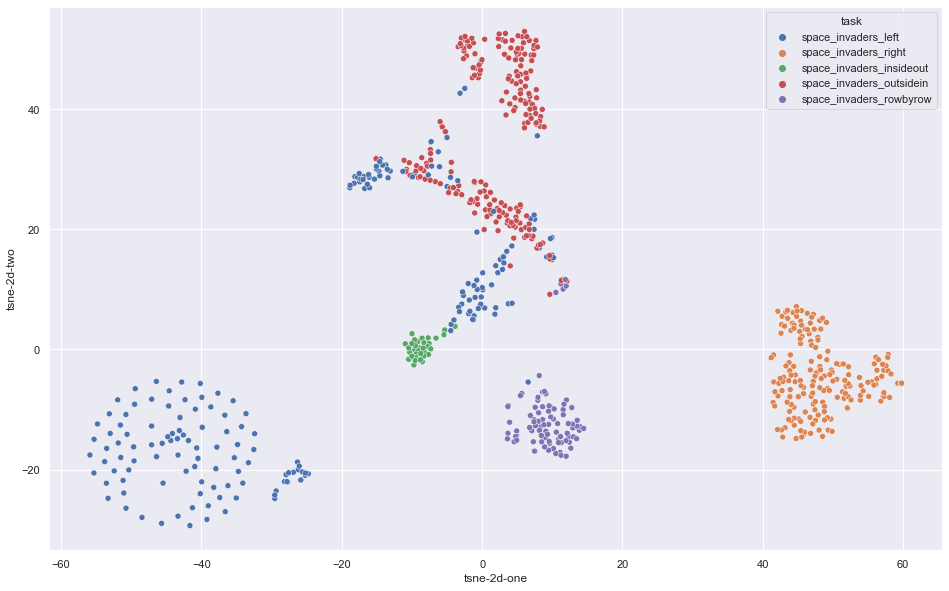

In [4]:
P1 = 'game_0>player_0'
P2 = 'game_0>player_1'
import math
data = []
for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right', 'space_invaders_rowbyrow', 'space_invaders_insideout', 'space_invaders_outsidein'] and task_adherence(ep) >= 0.8]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_insideout', 'space_invaders_outsidein'] and task_adherence(ep) >= 0.8]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right', 'space_invaders_rowbyrow', 'space_invaders_insideout', 'space_invaders_outsidein', 'space_invaders_insideout_email', 'space_invaders_insideout_socialmedia']]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right']]:
    if 'left' not in ep.keyword_data[P1] and  'right' not in ep.keyword_data[P1] and  'insideout' not in ep.keyword_data[P1] and  'outsidein' not in ep.keyword_data[P1] and  'rowbyrow' not in ep.keyword_data[P1]:
        print(f"data not found for episode {ep.episode_id}")
    else:
        d = {'task': ep.environment.task_id, 'length': ep.keyword_data[P1]['Time played'].total_seconds(), 'score': (ep.keyword_data[P1]['Score']),
            'left': ep.keyword_data[P1]['left'], 'right': ep.keyword_data[P1]['right'], 'insideout': ep.keyword_data[P1]['insideout'], 'outsidein': ep.keyword_data[P1]['outsidein'], 'rowbyrow': ep.keyword_data[P1]['rowbyrow'], }
        d.update(ep.keyword_data[P1]['action_dist_data'])
        data.append(d)

df = pandas.DataFrame(data)
df = df.fillna(0)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(init='pca')
# tsne = TSNE()
# df_subset = df[['left','right','insideout','outsidein','rowbyrow']]

df_subset = df[['left','right','insideout','outsidein','rowbyrow','action_0', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5', 'action_6',]]
# df_subset = df[['action_0', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5', 'action_6',]]
tsne_results = tsne.fit_transform(df_subset)

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="agent",
    hue="task",
    data=df_fig,
    hue_order=['space_invaders_left', 'space_invaders_right', 'space_invaders_insideout', 'space_invaders_outsidein', 'space_invaders_rowbyrow']
)
plt.savefig("tsne_multimodal_human.pdf",bbox_inches='tight')

In [5]:
df_orangecluster = df_fig.query('`tsne-2d-one` < -20').query('`tsne-2d-two` < 0').sort_values('score', 0)
df_orangecluster

,task,length,score,left,right,insideout,outsidein,rowbyrow,action_0,action_1,...,action_11,action_12,action_13,action_14,action_15,action_16,action_17,episode_length,tsne-2d-one,tsne-2d-two
46,space_invaders_left,14.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861,-43.329556,-17.587729
261,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-36.659664,-10.954067
262,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-37.793102,-16.273003
263,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-37.793102,-16.273003
264,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-39.877831,-12.971297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-44.128925,-14.009044
149,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-43.329556,-17.587729
148,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-43.329556,-17.587729
157,space_invaders_left,46.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2767,-43.411964,-14.869430


/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


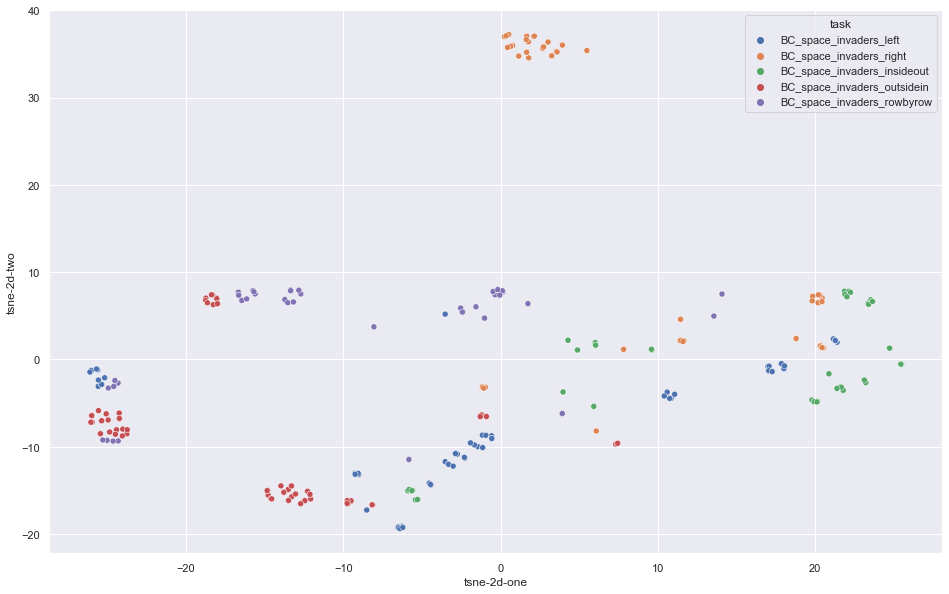

In [6]:
P1 = 'game_0>player_0'
P2 = 'game_0>player_1'
import math
data = []
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['synthetic_bc_left', 'synthetic_bc_right', 'synthetic_bc_rowbyrow', 'synthetic_bc_insideout', 'synthetic_bc_outsidein',]]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['synthetic_bc_insideout', 'synthetic_bc_outsidein',]]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['synthetic_bc_left', 'synthetic_bc_right', ]]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right', 'space_invaders_rowbyrow', 'space_invaders_insideout', 'space_invaders_outsidein', 'space_invaders_insideout_email', 'space_invaders_insideout_socialmedia']]:
# for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right']]:
for ep in [ep for ep in all_episodes if ep.environment.task_id in ['BC_space_invaders_left', 'BC_space_invaders_right', 'BC_space_invaders_rowbyrow', 'BC_space_invaders_insideout', 'BC_space_invaders_outsidein']]:
    if 'left' not in ep.keyword_data[P1] and  'right' not in ep.keyword_data[P1] and  'insideout' not in ep.keyword_data[P1] and  'outsidein' not in ep.keyword_data[P1] and  'rowbyrow' not in ep.keyword_data[P1]:
        print(f"data not found for episode {ep.episode_id}")
    else:
        d = {'task': ep.environment.task_id,
            'left': ep.keyword_data[P1]['left'], 'right': ep.keyword_data[P1]['right'], 'insideout': ep.keyword_data[P1]['insideout'], 'outsidein': ep.keyword_data[P1]['outsidein'], 'rowbyrow': ep.keyword_data[P1]['rowbyrow'], }
        d.update(ep.keyword_data[P1]['action_dist_data'])
        data.append(d)

df = pandas.DataFrame(data)
df = df.fillna(0)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(init='pca')
# tsne = TSNE()
df_subset = df[['left','right','insideout','outsidein','rowbyrow','action_0', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5','action_6',]]
# df_subset = df.drop('task', 1).drop('score', 1).drop('length',1).drop('episode_length',1)
tsne_results = tsne.fit_transform(df_subset)

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="agent",
    hue="task",
    data=df_fig,
    hue_order=['BC_space_invaders_left', 'BC_space_invaders_right', 'BC_space_invaders_insideout', 'BC_space_invaders_outsidein', 'BC_space_invaders_rowbyrow']
)
plt.savefig("tsne_multimodal_cloned.pdf",bbox_inches='tight')

In [7]:
print(df.columns)

Index(['task', 'left', 'right', 'insideout', 'outsidein', 'rowbyrow',
       'action_0', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5',
       'action_6', 'action_7', 'action_8', 'action_9', 'action_10',
       'action_11', 'action_12', 'action_13', 'action_14', 'action_15',
       'action_16', 'action_17', 'episode_length'],
      dtype='object')


/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


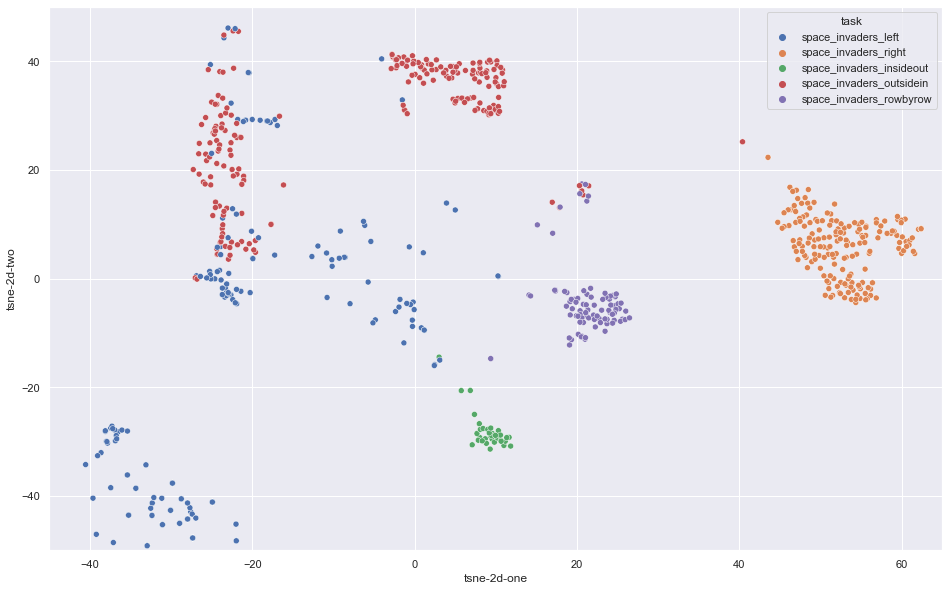

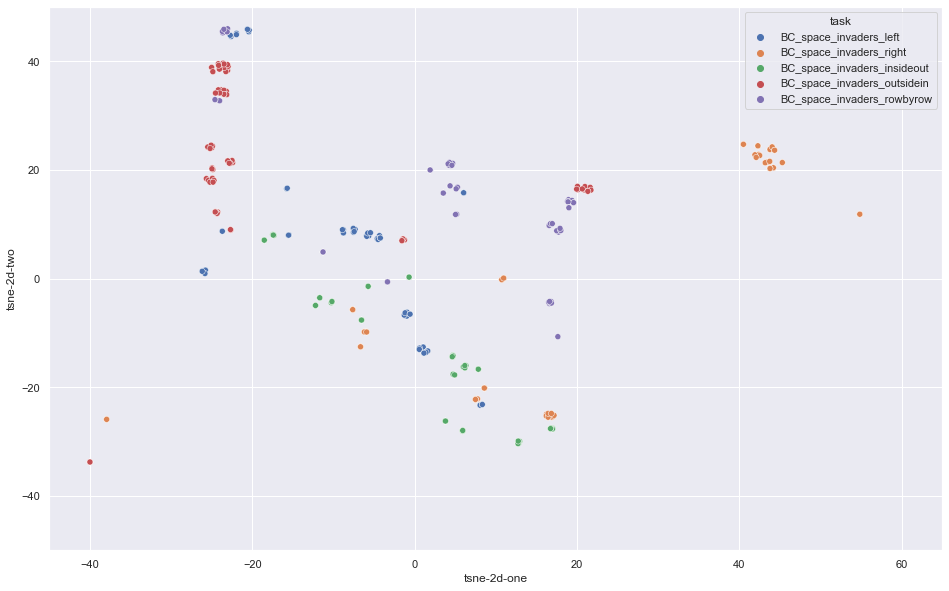

<Figure size 1152x720 with 0 Axes>

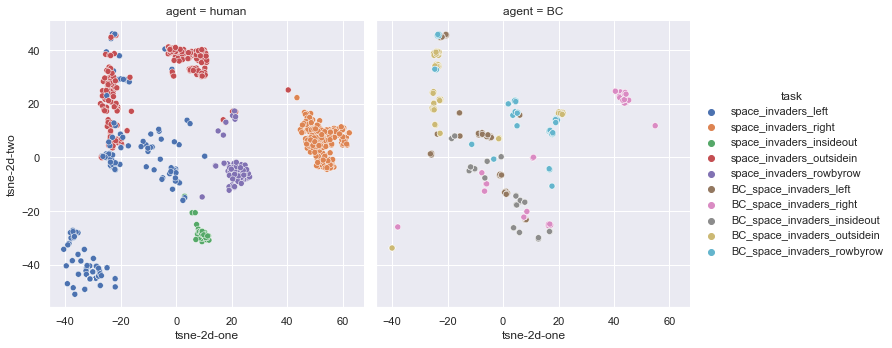

In [13]:
P1 = 'game_0>player_0'
P2 = 'game_0>player_1'
import math
data = []
# human data
for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_left', 'space_invaders_right', 'space_invaders_rowbyrow', 'space_invaders_insideout', 'space_invaders_outsidein'] and task_adherence(ep) >= 0.8]:
    if 'left' not in ep.keyword_data[P1] and  'right' not in ep.keyword_data[P1] and  'insideout' not in ep.keyword_data[P1] and  'outsidein' not in ep.keyword_data[P1] and  'rowbyrow' not in ep.keyword_data[P1]:
        print(f"data not found for episode {ep.episode_id}")
    else:
        d = {'agent': 'human', 'task': ep.environment.task_id, 'length': ep.keyword_data[P1]['Time played'].total_seconds(), 'score': (ep.keyword_data[P1]['Score']),
            'left': ep.keyword_data[P1]['left'], 'right': ep.keyword_data[P1]['right'], 'insideout': ep.keyword_data[P1]['insideout'], 'outsidein': ep.keyword_data[P1]['outsidein'], 'rowbyrow': ep.keyword_data[P1]['rowbyrow'], }
        d.update(ep.keyword_data[P1]['action_dist_data'])
        data.append(d)
# BC data
for ep in [ep for ep in all_episodes if ep.environment.task_id in ['BC_space_invaders_left', 'BC_space_invaders_right', 'BC_space_invaders_rowbyrow', 'BC_space_invaders_insideout', 'BC_space_invaders_outsidein']]:
    if 'left' not in ep.keyword_data[P1] and  'right' not in ep.keyword_data[P1] and  'insideout' not in ep.keyword_data[P1] and  'outsidein' not in ep.keyword_data[P1] and  'rowbyrow' not in ep.keyword_data[P1]:
        print(f"data not found for episode {ep.episode_id}")
    else:
        d = {'agent': 'BC', 'task': ep.environment.task_id,
            'left': ep.keyword_data[P1]['left'], 'right': ep.keyword_data[P1]['right'], 'insideout': ep.keyword_data[P1]['insideout'], 'outsidein': ep.keyword_data[P1]['outsidein'], 'rowbyrow': ep.keyword_data[P1]['rowbyrow'], }
        d.update(ep.keyword_data[P1]['action_dist_data'])
        data.append(d)

df = pandas.DataFrame(data)
df = df.fillna(0)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(init='pca')
# tsne = TSNE()
df_subset = df[['left','right','insideout','outsidein','rowbyrow','action_0', 'action_1', 'action_2', 'action_3', 'action_4', 'action_5','action_6',]]
# df_subset = df.drop('task', 1).drop('score', 1).drop('length',1).drop('episode_length',1)
tsne_results = tsne.fit_transform(df_subset)

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
df_fig = df_fig[df_fig['agent'] == 'human']
plt.figure(figsize=(16,10))
plt.xlim(-45, 65)
plt.ylim(-50,50)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="agent",
    hue="task",
    data=df_fig,
    hue_order=['space_invaders_left', 'space_invaders_right', 'space_invaders_insideout', 'space_invaders_outsidein', 'space_invaders_rowbyrow']
)
plt.savefig("tsne_multimodal_joint_human.pdf",bbox_inches='tight')

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
df_fig = df_fig[df_fig['agent'] == 'BC']
plt.figure(figsize=(16,10))
plt.xlim(-45, 65)
plt.ylim(-50,50)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="agent",
    hue="task",
    data=df_fig,
    hue_order=['BC_space_invaders_left', 'BC_space_invaders_right', 'BC_space_invaders_insideout', 'BC_space_invaders_outsidein', 'BC_space_invaders_rowbyrow']
)
plt.savefig("tsne_multimodal_joint_BC.pdf",bbox_inches='tight')

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.relplot(
    x="tsne-2d-one", y="tsne-2d-two",
    col='agent',
    # style="agent",
    hue="task",
    data=df_fig,
    hue_order=['space_invaders_left', 'space_invaders_right', 'space_invaders_insideout', 'space_invaders_outsidein', 'space_invaders_rowbyrow', 'BC_space_invaders_left', 'BC_space_invaders_right', 'BC_space_invaders_insideout', 'BC_space_invaders_outsidein', 'BC_space_invaders_rowbyrow']
)
plt.savefig("tsne_multimodal_joint_twocols.pdf",bbox_inches='tight')
